In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack

Imported MigPreFuncoes now
Imported SlantStack now


In [2]:
dx=1
nt=nz=120
ntr=80 
#dt=0.004
dt=1
dz=1
c=250

#1/250 = 0.004 = dt

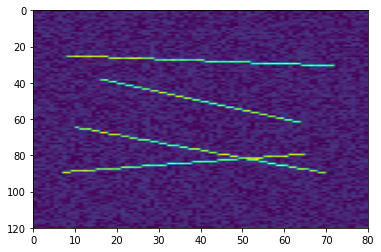

In [3]:
MOD = np.zeros([ntr,nt])

x_ini_1 = int(np.round(1*ntr/5))
x_fim_1 = int(np.round(4*ntr/5))

x_ini_2 = int(np.round(1*ntr/8))
x_fim_2 = int(np.round(7*ntr/8))

x_ini_3 = int(np.round(1*ntr/10))
x_fim_3 = int(np.round(9*ntr/10))

x_ini_4 = int(np.round(1*ntr/11))
x_fim_4 = int(np.round(9*ntr/11))

theta=np.radians(30)
theta2=np.radians(25)
theta3=np.radians(5)
theta4=np.radians(10)
      
for i in range(x_ini_1,x_fim_1):
    z = int(np.round(i*np.sin(theta)) + np.round(nt/4))
    if z < nt:
        MOD[i,z]=1
    
for i in range(x_ini_2,x_fim_2):
    z = int(np.round(i*np.sin(theta2)) + np.round(nt/2))
    if z < nt:
        MOD[i,z]=1
              
for i in range(x_ini_3,x_fim_3):
    z = int(np.round(i*np.sin(theta3)) + np.round(nt/5))
    if z < nt:
        MOD[i,z]=1
              
for i in range(x_ini_4,x_fim_4):
    z = int(np.round(i*np.sin(-theta4)) + np.round(3*nt/4))
    if z < nt:
        MOD[i,z]=1
              

nn = np.random.rand(ntr,nt)
MOD = MOD+(nn-0.5)*0.2

plt.imshow(MOD.T, aspect="auto", extent=[0,dx*ntr,nz*dz,0])
plt.show()

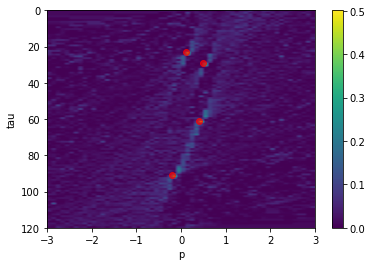

In [4]:
MOD1 = np.zeros([ntr,nt])
MOD2 = np.zeros([ntr,nt])
MOD3 = np.zeros([ntr,nt])
MOD4 = np.zeros([ntr,nt])

for i in range(x_ini_1,x_fim_1):
    z = int(np.round(i*np.sin(theta)) + np.round(nt/4))
    if z < nt:
        MOD1[i,z]=1
    
for i in range(x_ini_2,x_fim_2):
    z = int(np.round(i*np.sin(theta2)) + np.round(nt/2))
    if z < nt:
        MOD2[i,z]=1
              
for i in range(x_ini_3,x_fim_3):
    z = int(np.round(i*np.sin(theta3)) + np.round(nt/5))
    if z < nt:
        MOD3[i,z]=1
              
for i in range(x_ini_4,x_fim_4):
    z = int(np.round(i*np.sin(-theta4)) + np.round(3*nt/4))
    if z < nt:
        MOD4[i,z]=1

    
nn = np.random.rand(ntr,nt)
MOD1 = MOD1+(nn-0.5)*0.2
MOD2 = MOD2+(nn-0.5)*0.2
MOD3 = MOD3+(nn-0.5)*0.2
MOD4 = MOD4+(nn-0.5)*0.2

pmin=-3
pmax=3
dp=0.1

S,pmaxS,taumaxS,smax,ip,itau = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD.T,1.0,dt,0,0)
S1,pmaxS1,taumaxS1,smax1,ip1,itau1 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD1.T,1.0,dt,0,0)
S2,pmaxS2,taumaxS2,smax2,ip2,itau2 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD2.T,1.0,dt,0,0)
S3,pmaxS3,taumaxS3,smax3,ip3,itau3 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD3.T,1.0,dt,0,0)
S4,pmaxS4,taumaxS4,smax4,ip4,itau4 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD4.T,1.0,dt,0,0)

plt.imshow(S,extent=[pmin,pmax,nt*dt,0],aspect="auto")
plt.plot(pmaxS1,taumaxS1,'or', alpha=.7)
plt.plot(pmaxS2,taumaxS2,'or', alpha=.7)
plt.plot(pmaxS3,taumaxS3,'or', alpha=.7)
plt.plot(pmaxS4,taumaxS4,'or', alpha=.7)
plt.colorbar()
plt.xlabel('p')
plt.ylabel('tau')
plt.show()

In [5]:
t1 = np.degrees(np.arctan(pmaxS1))
t2 = np.degrees(np.arctan(pmaxS2))
t3 = np.degrees(np.arctan(pmaxS3))
t4 = np.degrees(np.arctan(pmaxS4))

print("pmax MOD1 =", pmaxS1)
print(f"theta 1 = {t1} graus")

print("\npmax MOD2 =", pmaxS2)
print(f"theta 2 = {t2} graus")

print("\npmax MOD3 =", pmaxS3)
print(f"theta 3 = {t3} graus")

print("\npmax MOD4 =", pmaxS4)
print(f"theta 4 = {t4} graus")

pmax MOD1 = 0.5000000000000031
theta 1 = 26.565051177078132 graus

pmax MOD2 = 0.400000000000003
theta 2 = 21.801409486351965 graus

pmax MOD3 = 0.10000000000000275
theta 3 = 5.710593137499799 graus

pmax MOD4 = -0.1999999999999975
theta 4 = -11.309932474020076 graus


**********

### Rodando a Janela

**********

In [6]:
#xwin=twin=25
#m_taumax,m_pmax, s_max = SlantStack.local_window(MOD.T,xwin,twin,dx,dt)

In [7]:
#with open("Data/CSG/janela", "wb") as f:
#    np.save(f, m_pmax)

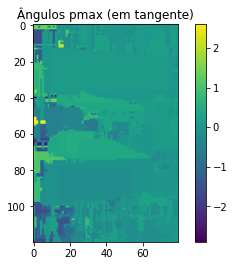

In [8]:
with open("Data/CSG/janela", "rb") as f:
    tst = np.load(f)

#plt.figure(figsize=(5,6))
plt.imshow(tst)
plt.title("Ângulos pmax (em tangente)")
plt.colorbar()
plt.show()

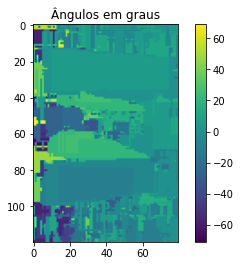

In [9]:
m_theta = np.degrees(np.arctan(tst))
plt.imshow(m_theta)
plt.title("Ângulos em graus")
plt.colorbar()
plt.show()

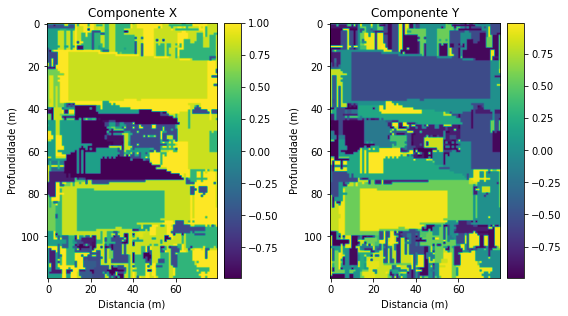

In [10]:
X = np.cos(m_theta) 
Y = np.sin(m_theta)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

*********

Criando a tabela do tempo de trânsito.

Considerei o dx do nosso modelo como 1 metro. 

Como dt=0.004 s e nt=120, o tempo máximo é 0.48 s

velocidade do modelo c = 120/0.48 = 250 m/s

**********

(120, 80)


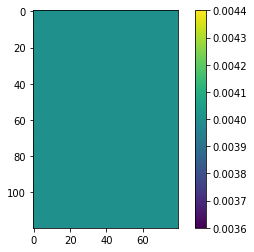

In [11]:
c = 250

SW=np.ones([nt,ntr])*1/c
print(SW.shape)
plt.imshow(SW)
plt.colorbar()
plt.show()

In [12]:
#TT=MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/raiosSlantStack.npy")

In [13]:
with open('Data/raiosSlantStack.npy', 'rb') as f:
    TTh = np.load(f)

print(f"TTh.shape={TTh.shape}")

TTh.shape=(80, 120, 80)


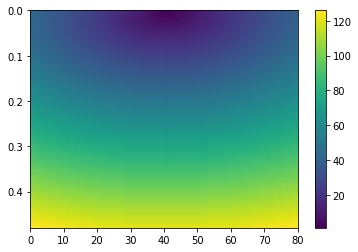

TSX.shape=(120, 80)


In [14]:
dt=0.004
TSX = (TTh[40,:,:]/dt+1).astype(int)  # Traveltime  (indexes)
plt.imshow(TSX,extent=[0, ntr*dx, nt*dt, 0], aspect='auto')
plt.colorbar()
plt.show()

timer=np.round(TTh/dt)+1

print(f"TSX.shape={TSX.shape}")

In [15]:
#Wavelet

nx=ntr
fr=40
nps=200
dt=.004
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
#print(nt)

nd2=nt+1; 
W=np.zeros(2*nt);
#print(W.shape)
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

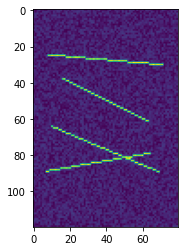

In [16]:
nx=ntr

#Modelo:
R = MOD.T

plt.imshow(R)
plt.show()

In [17]:
#### Create file with all shot gathers
#
#nsx=nx #105  #numero de tiros (pode ser no máximo o valor de TTh axis=0)
#ngx=nx #105   #numero de receptores (pode ser no máximo o valor de TTh axis=1)
##Loop over shots
#
#for isx in range(0,nsx,1):
#    print('shot', isx)
#    D = np.zeros([nt,ngx])
#    TSX = (TTh[isx,:,:]/dt+1).astype(int)  # Traveltime  (indexes)
#
#
#    # Loop Over Traces
#    for gx in range(0,ngx):
#        TXG=(TTh[gx,:,:]/dt+1).astype(int)  # Traveltime in heterogeneous medium (indexes)
#                         
#      
#        #Loop over time sample in a trace
#        for t in range(0,nt):
#            M=W[t-(TSX+TXG)+nt+1]*R
#            D[t,gx]=np.sum(M.flatten('F'));
#            #D[t,gx]=np.sum(M.flatten());
#        gather1=np.diff(D[:,:],n=2,axis=0);
#        
#    filename = 'Data/CSG/gather_shot{}'.format(isx)
#    with open(filename, 'wb') as f:
#        np.save(f, gather1)

In [18]:
files = []

for i in range(0,80,1):
    filename = 'Data/CSG/gather_shot{}'.format(i)
    
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

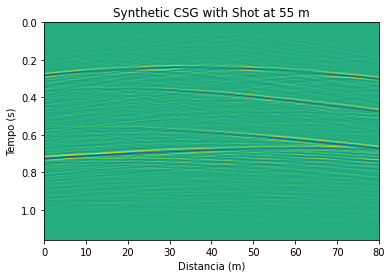

In [19]:
plt.imshow(files[40],aspect='auto',extent=[0, nx*dx, nt*dt, 0])

plt.title('Synthetic CSG with Shot at 55 m')
plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.show()

In [20]:
shot = 40
filename = 'Data/CSG/gather_shot{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1 = np.load(file)

win=20*dt
dwin=dt
app=15
isx=shot

### Migração convencional com janela e abertura

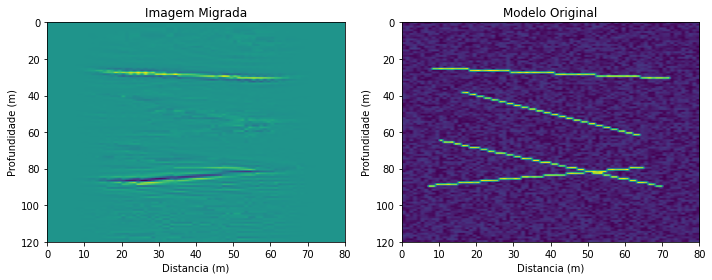

In [21]:
mig_winapp = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_winapp, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

### Migração de difrações (com janela e abertura) 

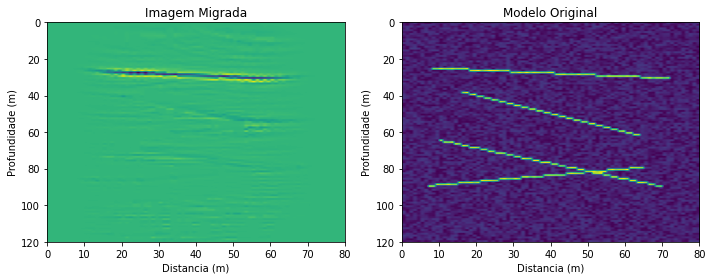

In [22]:
mig_diff = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

### Imagem migrada com stack das migrações convencionais

80it [08:41,  6.51s/it]


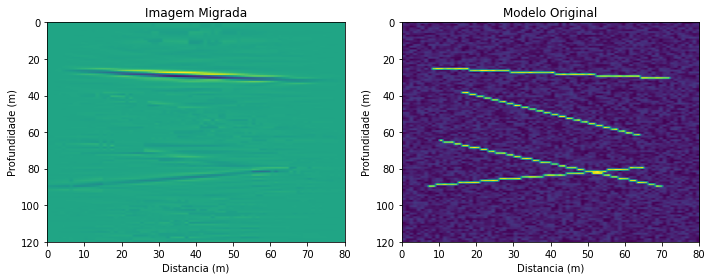

In [23]:
mig_stack = MigPreFuncoes.migstack_winapp(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

### Imagem migrada com stack das migrações de difrações

shot 0
shot 1
shot 2
shot 3
shot 4
shot 5
shot 6
shot 7
shot 8
shot 9
shot 10
shot 11
shot 12
shot 13
shot 14
shot 15
shot 16
shot 17
shot 18
shot 19
shot 20
shot 21
shot 22
shot 23
shot 24
shot 25
shot 26
shot 27
shot 28
shot 29
shot 30
shot 31
shot 32
shot 33
shot 34
shot 35
shot 36
shot 37
shot 38
shot 39
shot 40
shot 41
shot 42
shot 43
shot 44
shot 45
shot 46
shot 47
shot 48
shot 49
shot 50
shot 51
shot 52
shot 53
shot 54
shot 55
shot 56
shot 57
shot 58
shot 59
shot 60
shot 61
shot 62
shot 63
shot 64
shot 65
shot 66
shot 67
shot 68
shot 69
shot 70
shot 71
shot 72
shot 73
shot 74
shot 75
shot 76
shot 77
shot 78
shot 79


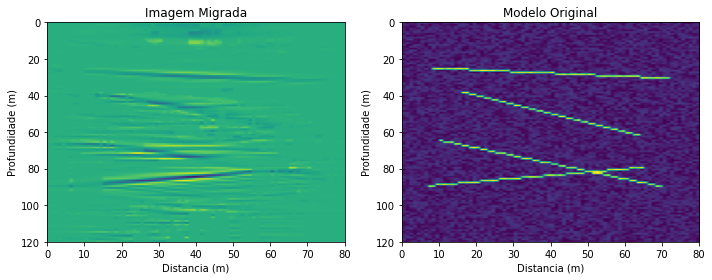

In [24]:
mig_stack_diff = MigPreFuncoes.migstack_winapp_diff(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()